In [204]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [205]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import LdaModel
from gensim.models import Phrases
from itertools import chain
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns

In [206]:
%matplotlib inline

In [207]:
train = pd.read_csv('../data/external/kaggle/train.csv')
test = pd.read_csv('../data/external/kaggle/test.csv')
y = pd.read_csv('../data/external/kaggle/train.csv')['target'].values
tokenizer = RegexpTokenizer(r'\w+')

In [208]:
def preview_corpus(corpus):
    for i,doc in enumerate(corpus[:5],1):
        print(f'Document {i}: {doc}')
        print()
        
def display_corr(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corr.round(2),mask=mask, annot=True, cbar=False, linewidths=0.3, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large');
    return fig, ax        

In [209]:
corpus = train['text'].values
corpus = [doc.lower() for doc in corpus]
corpus = [tokenizer.tokenize(doc) for doc in corpus]
corpus = [[token for token in doc if (not token.isnumeric() and len(token) > 1)] for doc in corpus]
preview_corpus(corpus)

Document 1: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Document 2: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']

Document 3: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']

Document 4: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']

Document 5: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'school']



In [210]:
%%time

bigram = Phrases(corpus, min_count=5)
trigram = Phrases(bigram[corpus], min_count=5)
fourgram = Phrases(trigram[corpus], min_count=5)
for doc in corpus:
    bigrams = [b for b in bigram[doc] if b.count('_') == 1]
    trigrams = [t for t in trigram[bigram[doc]] if t.count('_') == 2]
    fourgrams = [f for f in fourgram[trigram[bigram[doc]]] if f.count('_') == 3]
    doc.extend(list(chain(*[bigrams, trigrams, fourgrams])))
preview_corpus(corpus)

Document 1: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Document 2: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada', 'forest_fire']

Document 3: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']

Document 4: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']

Document 5: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'school', 'just_got']

CPU times: user 4.15 s, sys: 3.69 ms, total: 4.15 s
Wall time: 4.15 s


In [211]:
dictionary = Dictionary(corpus)
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in corpus]
preview_corpus(corpus)

Document 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]

Document 2: [(10, 1), (11, 1), (12, 1), (13, 1)]

Document 3: [(0, 1), (1, 2), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1)]

Document 4: [(16, 1), (17, 1), (23, 1), (24, 1)]

Document 5: [(8, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)]



In [212]:
print(f'Corpus: {len(corpus)} Tweets')
print(f'Dictionary: {len(dictionary)} Tokens')

Corpus: 7613 Tweets
Dictionary: 974 Tokens


In [213]:
%%time
num_topics = 15
chunksize = 7000
passes = 30
iterations = 400
eval_every = None

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

CPU times: user 58.1 s, sys: 108 ms, total: 58.2 s
Wall time: 58.1 s


In [214]:
%%time
topics = [model.get_document_topics(doc) for doc in corpus]
topics = [dict(topic_dist) for topic_dist in topics]
topics = pd.DataFrame(topics).fillna(0)
topics

CPU times: user 2.15 s, sys: 32.2 ms, total: 2.19 s
Wall time: 2.15 s


,0,1,4,6,12,2,5,10,11,13,14,3,9,8,7
0,0.236948,0.015409,0.298779,0.107489,0.295834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.034755,0.010227,0.010707,0.011964,0.013656,0.018719,0.011386,0.419398,0.419273,0.010685,0.000000,0.000000,0.0,0.0
2,0.000000,0.011313,0.272695,0.000000,0.000000,0.000000,0.678561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.417828,0.010226,0.010707,0.011964,0.013655,0.018718,0.011386,0.000000,0.000000,0.158399,0.299656,0.000000,0.0,0.0
4,0.000000,0.015465,0.000000,0.287126,0.000000,0.000000,0.459496,0.000000,0.000000,0.000000,0.000000,0.190733,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.000000,0.464817,0.000000,0.469784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
7609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.956915,0.000000,0.000000,0.0,0.0
7610,0.000000,0.615815,0.000000,0.000000,0.000000,0.011326,0.015524,0.274749,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
7611,0.000000,0.015430,0.000000,0.000000,0.000000,0.000000,0.000000,0.467827,0.000000,0.000000,0.000000,0.000000,0.460979,0.0,0.0


In [215]:
topics.values.shape

(7613, 15)

In [216]:
topics['label'] = y

In [217]:
topics

,0,1,4,6,12,2,5,10,11,13,14,3,9,8,7,label
0,0.236948,0.015409,0.298779,0.107489,0.295834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
1,0.000000,0.034755,0.010227,0.010707,0.011964,0.013656,0.018719,0.011386,0.419398,0.419273,0.010685,0.000000,0.000000,0.0,0.0,1
2,0.000000,0.011313,0.272695,0.000000,0.000000,0.000000,0.678561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
3,0.000000,0.417828,0.010226,0.010707,0.011964,0.013655,0.018718,0.011386,0.000000,0.000000,0.158399,0.299656,0.000000,0.0,0.0,1
4,0.000000,0.015465,0.000000,0.287126,0.000000,0.000000,0.459496,0.000000,0.000000,0.000000,0.000000,0.190733,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.000000,0.464817,0.000000,0.469784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
7609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.956915,0.000000,0.000000,0.0,0.0,1
7610,0.000000,0.615815,0.000000,0.000000,0.000000,0.011326,0.015524,0.274749,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
7611,0.000000,0.015430,0.000000,0.000000,0.000000,0.000000,0.000000,0.467827,0.000000,0.000000,0.000000,0.000000,0.460979,0.0,0.0,1


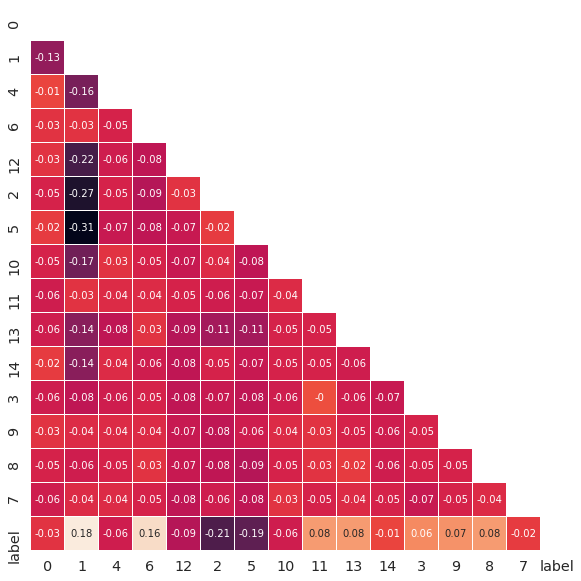

In [218]:
_,_ = display_corr(topics)

In [219]:
model.show_topics(num_words=20)

[(7,
  '0.045*"co" + 0.039*"gt" + 0.032*"û_" + 0.025*"red" + 0.024*"body" + 0.023*"full" + 0.022*"white" + 0.021*"in" + 0.020*"with" + 0.019*"old" + 0.019*"up" + 0.019*"year" + 0.019*"https" + 0.019*"under" + 0.018*"year_old" + 0.017*"airport" + 0.016*"this" + 0.016*"where" + 0.016*"amp" + 0.016*"helicopter"'),
 (9,
  '0.087*"wounds" + 0.067*"in" + 0.038*"of" + 0.029*"suicide" + 0.028*"car" + 0.022*"my" + 0.019*"bomber" + 0.018*"army" + 0.017*"into" + 0.017*"train" + 0.016*"is" + 0.016*"to" + 0.016*"old" + 0.015*"bomb" + 0.015*"an" + 0.013*"land" + 0.013*"wreck" + 0.013*"who" + 0.013*"collided" + 0.011*"detonated"'),
 (11,
  '0.061*"who_were" + 0.042*"new" + 0.033*"fire" + 0.026*"on" + 0.024*"weather" + 0.022*"û_" + 0.022*"for" + 0.022*"please" + 0.021*"update" + 0.020*"were" + 0.019*"warning" + 0.019*"make" + 0.018*"at" + 0.017*"severe" + 0.017*"down" + 0.017*"one" + 0.016*"another" + 0.016*"am" + 0.016*"and" + 0.016*"rain"'),
 (8,
  '0.065*"co" + 0.062*"http_co" + 0.062*"http" + 0.06